In [1]:
! pip install pytorch-lightning

In [2]:
%matplotlib inline
import pytorch_lightning as pl
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Module

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='data', batch_size=64, num_workers=0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.ToTensor()

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)

    def setup(self, stage=None):
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train = mnist_full

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

# GAN Model

## Discriminator

In [4]:
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs, n_classes=10, embed_dim=10):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*3)  # (784 + embed_dim) x hidden_size1
        self.fc2 = nn.Linear(hidden_dim*3, hidden_dim*2)
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*2, n_outputs)

        # labels embedding layer
        self.embed_label = nn.Embedding(n_classes, embed_dim)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, labels):
        x = x.view(-1, 784)   # batch_size x (784)
        # labels embedding
        labels = self.embed_label(labels)     # batch_size x embed_dim
        # Concatenate labels and images
        x = torch.cat((labels, x), dim=-1)    # batch_size x (784 + embed_dim)
        
        # hidden layers
        x = self.fc1(func.leaky_relu(x, 0.2))
        x = self.dropout(x)
        x = self.fc2(func.leaky_relu(x, 0.2))
        x = self.dropout(x)

        # final layer
        out = self.fc3(x)   # batch_size x 1
        
        return out

## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs, n_classes=10, embed_dim=10):
        super(Generator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*2)  # (z_size + embed_dim) x hidden_dim
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2, 0.8)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim*3)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim*3, 0.8)
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*3, n_outputs)

        # labels embedding layer
        self.embed_label = nn.Embedding(n_classes, embed_dim)
        
        # dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, labels):

        # labels embedding
        labels = self.embed_label(labels)     # batch_size x embed_dim
        # Concatenate labels and z
        x = torch.cat((labels, x), dim=-1)    # batch_size x (embed_dim + z_size)

        # hidden layers
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
     
        # output
        out = func.tanh(self.fc3(x))  # batch_size x (28*28)
        
        return out

## GAN

In [6]:
criterion = nn.BCEWithLogitsLoss()
samples = []
sample_label = []
losses = []


class GAN(pl.LightningModule):
    def __init__(self, 
                 img_size: int = 784, 
                 z_size: int = 64, 
                 hidden_dim: int = 64, 
                 lr: float = 0.0002, 
                 n_classes: int = 10,
                 embed_dim: int = 10,
                 **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(n_inputs=z_size + embed_dim, hidden_dim=hidden_dim, n_outputs=img_size, 
                                   n_classes=n_classes, embed_dim=embed_dim).to(device)
        self.discriminator = Discriminator(n_inputs=img_size + embed_dim, hidden_dim=hidden_dim, n_outputs=1, 
                                           n_classes=n_classes, embed_dim=embed_dim).to(device)

        sample_size = 16
        self.fixed_z = torch.randn((sample_size, z_size)).to(device)
        self.fixed_labels = torch.randint(0, self.hparams.n_classes, (sample_size, )).to(device)

    def forward(self, z, labels):
        return self.generator(z, labels)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, real_img_label = batch
        
        batch_size = real_imgs.shape[0]
        # rescale input images from [0,1) to [-1, 1)
        real_imgs = real_imgs*2 - 1

        z = torch.randn((batch_size, self.hparams.z_size)).to(device)
        rand_labels = torch.randint(0, self.hparams.n_classes, (batch_size, )).to(device)

        # train discriminator
        if optimizer_idx == 1:

            # Train with real images
            real = torch.ones(batch_size).to(device)
            real = real * 0.9

            d_out_real = self.discriminator(real_imgs, real_img_label)
            real_loss = criterion(d_out_real.squeeze(), real)

            # Train with fake images
            fake_imgs = self.generator(z, rand_labels)
            fake = torch.zeros(batch_size).to(device)

            d_out_fake = self.discriminator(fake_imgs, rand_labels)
            fake_loss = criterion(d_out_fake.squeeze(), fake)

            # Add up loss
            d_loss = real_loss + fake_loss

            self.d_loss = d_loss.item()
            return d_loss

        # train generator
        if optimizer_idx == 0:

            # generate images
            fake_imgs = self.generator(z, rand_labels)

            real = torch.ones(batch_size).to(device)
            real = real * 0.9

            D_out_fake = self.discriminator(fake_imgs, rand_labels)
            g_loss = criterion(D_out_fake.squeeze(), real)   # flip labels

            self.g_loss = g_loss.item()
            return g_loss

    def configure_optimizers(self):
        lr = self.hparams.lr

        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_optimizer, d_optimizer], []

    def on_epoch_end(self):
        
        losses.append((self.d_loss, self.g_loss))

        # log sampled images
        self.generator.eval()
        sample_imgs = self.generator(self.fixed_z, self.fixed_labels)
        samples.append(sample_imgs)
        sample_label.append(self.fixed_labels)
        self.generator.train()

In [7]:
dm = MNISTDataModule()
model = GAN()
trainer = pl.Trainer(max_epochs=100, progress_bar_refresh_rate=20, gpus=1)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 186 K 
1 | discriminator | Discriminator | 177 K 
------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.456     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [8]:
import pickle as pkl
with open('CGAN_pl_train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
with open('CGAN_pl_labels.pkl', 'wb') as f:
    pkl.dump(sample_label, f)

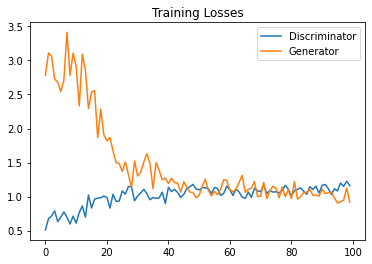

In [9]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Sample

## Training sample

In [10]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [11]:
# Load samples from generator, taken while training
with open('CGAN_pl_train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
with open('CGAN_pl_labels.pkl', 'rb') as f:
    sample_label = pkl.load(f)

In [12]:
print(sample_label[0])

tensor([5, 6, 4, 2, 5, 9, 1, 7, 0, 7, 4, 4, 4, 6, 6, 5], device='cuda:0')


tensor([5, 4, 5, 1, 0, 4], device='cuda:0')


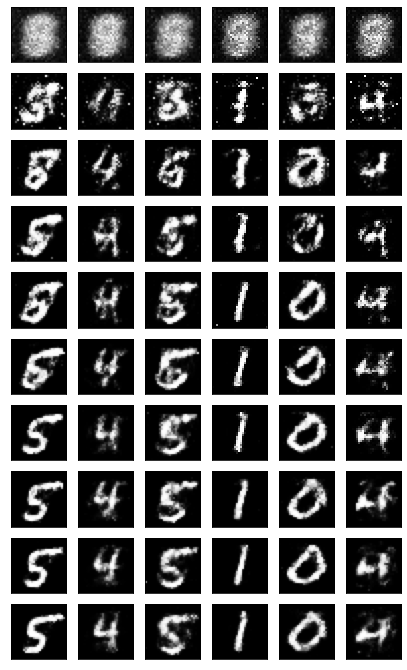

In [13]:
rows = 10 # show every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

print(sample_label[0][::int(len(samples[0])/cols)][:cols])

## Result sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


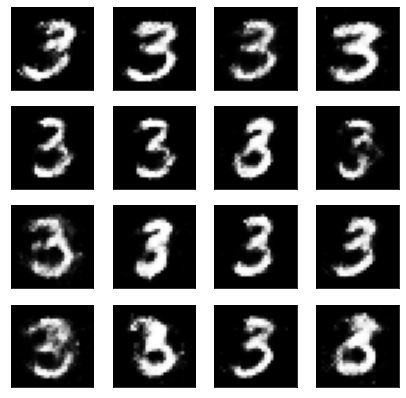

In [23]:
sample_size = 16
gen_label = 3
rand_z = torch.randn(sample_size, model.hparams.z_size)
labels = torch.ones(sample_size, dtype=int) * gen_label

model.eval()
rand_images = model(rand_z, labels)

view_samples(0, [rand_images])

In [15]:
# interpolation between two points in latent space
def interpolate(p1, p2, n_steps=10):
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	vectors = torch.cat(vectors).reshape(-1, model.hparams.z_size)
	return vectors

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


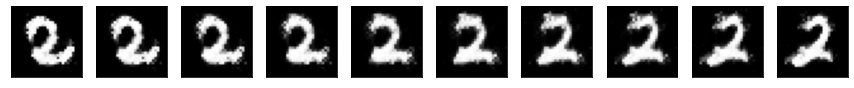

In [22]:
n_steps = 10
n_interpolate_samples = 2
gen_label = 2

z_input = torch.randn(n_interpolate_samples, model.hparams.z_size)
labels = torch.ones(n_steps, dtype=int) * gen_label

z_interpolate = interpolate(z_input[0], z_input[1], n_steps=n_steps)   # n_steps x z_size
interpolate_samples = model(z_interpolate, labels) * gen_label

fig, axes = plt.subplots(figsize=(15,15), nrows=1, ncols=10, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), interpolate_samples):
    img = img.detach().cpu()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')